In [164]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product

In [212]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def linear(x):
	return x

def tanh(x):
	return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def ReLU(x):
	return np.maximum(0, x)

class genetic_network():
	def __init__(self, architecture, population_size, initiation_method):
		self.architecture = architecture
		self.layers_number = len(self.architecture) - 1
		self.population_size = population_size
		self.population = self.population_initiation(self.population_size, initiation_method)

	def population_initiation(self, population_size, initiation_method):
		population = [None] * population_size

		for i in range(population_size):
			population[i] = self.speciment_initiation(initiation_method)

		return population

	def speciment_initiation(self, initiation_method):
		weights = [None] * self.layers_number
		biases = [None] * self.layers_number

		for i in range(self.layers_number):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i+1]

			if initiation_method == 'he':
				weights[i] = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weights[i] = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weights[i] = np.random.uniform(0, 1, (input_dim, output_dim))
			biases[i] = np.zeros((1, output_dim))

		return (weights, biases)
	
	def evolve(self, X, Y, iterations_num, required_error, activation_function, mutation_step, mutation_prob, selection_type, elite_ratio=None, draft_size=None, show_progess=True):
		error_history = [None]*iterations_num
		best_error = np.inf

		if show_progess:
			for i in tqdm(range(iterations_num)):
				error = self.check_error(X, Y, activation_function)
				error_history[i] = np.min(error)
				if np.min(error) < best_error:
					best_error = np.min(error)
					best_speciment = self.population[np.argmin(error)]
					if best_error < required_error: 
						print('Osiągnięto błąd poniżej', required_error)
						return error_history, best_speciment
					
				parents_A, parents_B = self.selection(error, selection_type, elite_ratio, draft_size)

				self.population = self.crossbreed(parents_A, parents_B)

				self.mutate(mutation_prob, mutation_step)
		else:
			for i in range(iterations_num):
				error = self.check_error(X, Y, activation_function)
				error_history[i] = np.min(error)
				if np.min(error) < best_error:
					best_error = np.min(error)
					best_speciment = self.population[np.argmin(error)]
					if best_error < required_error: 
						print('Osiągnięto błąd poniżej', required_error)
						return error_history, best_speciment
					
				parents_A, parents_B = self.selection(error, selection_type, elite_ratio, draft_size)

				self.population = self.crossbreed(parents_A, parents_B)

				self.mutate(mutation_prob, mutation_step)

		return error_history, best_speciment

	def check_error(self, X, Y, activation_function):
		error = np.empty(self.population_size)

		for j in range(self.population_size):
			activations = X
			weights = self.population[j][0]
			biases = self.population[j][1]

			for i in range(self.layers_number):
				preactivations = np.dot(activations, weights[i]) + biases[i]

				if i < self.layers_number:
					activations = activation_function(preactivations)
				else:
					activations = linear(preactivations)

			error[j] = np.mean((Y - activations)**2)

		return error
	
	def mutate(self, mutation_prob, mutation_step):
		speciment_choice = np.random.choice(self.population_size, size=int(mutation_prob*self.population_size))
		mutation_type = np.random.randint(0, 2, size=len(speciment_choice))
		layer_choice = np.random.randint(0, self.layers_number, size=len(speciment_choice))
		mutation_size = np.random.uniform(0, mutation_step, size=len(speciment_choice))

		for i in range(len(speciment_choice)):
			matrix = self.population[speciment_choice[i]][mutation_type[i]][layer_choice[i]]
			index = np.random.randint(matrix.shape)
			matrix[index[0], index[1]] += mutation_size[i]

	def check_fitness(self, error):
		return np.abs(error - np.max(error))

	def selection(self, error, selection_type, elite_ratio=None, draft_size=None):
		def elite(fitness, elite_ratio):
			ranks = np.argsort(-fitness)
			ordered_population = [self.population[i] for i in ranks]
			elite_size = int(self.population_size * elite_ratio)
			rest_fitness = fitness[elite_size:]

			return ordered_population[:elite_size], ordered_population[elite_size:], rest_fitness
		
		def roulette(fitness, population):
			population_size = len(population)
			prob = fitness / (np.sum(fitness) + np.finfo(float).eps)

			parent_A_idx = np.random.choice(population_size, size=population_size, p=prob)
			parent_B_idx = np.random.choice(population_size, size=population_size, p=prob)

			parent_A = [population[i] for i in parent_A_idx]
			parent_B = [population[i] for i in parent_B_idx]

			return parent_A, parent_B
		
		def rank(fitness, population):
			population_size = len(population)
			cutoff = 0.5
			grace = 0.2
			prob_lambda = -np.log(grace)/(cutoff*self.population_size)

			ranks = np.argsort(-fitness)
			ordered_population = [population[i] for i in ranks]
			positions = np.arange(population_size)
			prob = np.exp(-prob_lambda*positions)
			prob /= np.sum(prob)

			parent_A_idx = np.random.choice(population_size, size=population_size, p=prob)
			parent_B_idx = np.random.choice(population_size, size=population_size, p=prob)

			parent_A = [ordered_population[i] for i in parent_A_idx]
			parent_B = [ordered_population[i] for i in parent_B_idx]

			return parent_A, parent_B

		def tournament(fitness, population, draft_size):
			population_size = len(population)

			candidate_A = np.random.choice(population_size, size=(population_size, draft_size))
			candidate_B = np.random.choice(population_size, size=(population_size, draft_size))
			
			best_candidate_A = np.argmax(fitness[candidate_A], axis=1)
			best_candidate_B = np.argmax(fitness[candidate_B], axis=1)

			best_candidate_A_idx = candidate_A[np.arange(len(candidate_A)), best_candidate_A]
			best_candidate_B_idx = candidate_B[np.arange(len(candidate_B)), best_candidate_B]

			parent_A = [population[i] for i in best_candidate_A_idx]
			parent_B = [population[i] for i in best_candidate_B_idx]

			return parent_A, parent_B
		
		fitness = self.check_fitness(error)
		if elite_ratio != None:
			elite_parents, rest_population, fitness = elite(fitness, elite_ratio)
			match selection_type:
				case 'roulette':
					parents_A, parents_B = roulette(fitness, rest_population)
					parents_A += elite_parents
					parents_B += elite_parents
				case 'tournament':
					parents_A, parents_B = tournament(fitness, rest_population, draft_size)
					parents_A += elite_parents
					parents_B += elite_parents
				case 'rank':
					parents_A, parents_B = rank(fitness, rest_population)
					parents_A += elite_parents
					parents_B += elite_parents
		else:
			match selection_type:
				case 'roulette':
					parents_A, parents_B = roulette(fitness, self.population)
				case 'tournament':
					parents_A, parents_B = tournament(fitness, self.population, draft_size)
				case 'rank':
					parents_A, parents_B = rank(fitness, self.population)

		return (parents_A, parents_B)

	def crossbreed(self, parents_A, parents_B):
		children = [None] * self.population_size

		for i in range(self.population_size):
			weights_child = [None] * self.layers_number
			biases_child = [None] * self.layers_number

			for j in range(self.layers_number):
				weights_A = parents_A[i][0][j]
				biases_A = parents_A[i][1][j]
				weights_B = parents_B[i][0][j]
				biases_B = parents_B[i][1][j]

				weights_mask = np.random.randint(0, 2, size=weights_A.shape)
				biases_mask = np.random.randint(0, 2, size=biases_A.shape)

				weights_child[j] = np.where(weights_mask, weights_A, weights_B)
				biases_child[j] = np.where(biases_mask, biases_A, biases_B)

			children[i] = (weights_child, biases_child)

		return children

def grid_search(param_grid, X, Y):
	best_speciment_record = []
	error_history_record = []

	for config in tqdm(param_grid, desc='Progress'):
		(architecture,
		population_size,
		initiation_method,
		required_error,
		iterations_num,
		activation_function,
		mutation_step,
		mutation_prob,
		selection_type,
		elite_ratio,
		draft_size) = config
		
		run = genetic_network(architecture, population_size, initiation_method)

		error_history, best_speciment = run.evolve(
			X = X,
			Y = Y,
			iterations_num = iterations_num,
			required_error = required_error,
			activation_function = activation_function,
			mutation_step = mutation_step,
			mutation_prob = mutation_prob,
			selection_type = selection_type,
			elite_ratio = elite_ratio,
			draft_size = draft_size,
			show_progess = False)
		
		error_history_record.append(error_history)
		best_speciment_record.append(best_speciment)

	return error_history_record, best_speciment_record

def plot_error_history(error_history):
	error_history = [x for x in error_history if x is not None]
	print('best error', np.min(error_history))

	x = np.arange(0, len(error_history), 1)
	plt.plot(x, error_history, label='best', color='red')
	plt.xlabel('Iterations')
	plt.ylabel('Error')
	plt.title('Mean and best score in iterations')
	plt.legend()
	plt.grid(True)
	plt.show()

def visualize_speciment(architecture, speciment):
	weights = speciment[0]
	# biases = speciment[1]
	G = nx.DiGraph()
	pos = {}
	edge_colors = []
	edge_widths = []

	for layer_idx, num_nodes in enumerate(architecture):
		for node_idx in range(num_nodes):
			node_name = f"L{layer_idx}_N{node_idx}"
			pos[node_name] = (layer_idx, -node_idx)  
			G.add_node(node_name)
			
			if layer_idx > 0:
				for prev_idx in range(architecture[layer_idx - 1]):
					prev_name = f"L{layer_idx-1}_N{prev_idx}"
					weight = weights[layer_idx-1][prev_idx][node_idx]

					if weight != 0:
						G.add_edge(prev_name, node_name)
						edge_colors.append('red' if weight < 0 else 'green')
						edge_widths.append(np.log(abs(weight)))

	plt.figure(figsize=(10, 5))
	nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
	plt.show()

def standardize_data(data):
	mean = np.mean(data, axis=0)
	std = np.std(data, axis=0)
	new_data = (data - mean) / std

	return new_data, mean, std

def destandardize_data(data, mean, std):
	return data * std + mean

# IRIS

In [156]:
iris = pd.read_csv("../data/iris/iris.data", header=None).to_numpy()
iris_X = iris[:, (0,1,2,3)]
iris_Y = iris[:, 4]
iris_dict = {label: idx for idx, label in enumerate(np.unique(iris_Y))}
iris_Y = [iris_dict[label] for label in iris_Y]

In [189]:
iris_algo = genetic_network(architecture=[4, 5, 1], 
                       population_size=100, 
                       initiation_method='he')

iris_error_history, iris_best_speciment = iris_algo.evolve(X = iris_X,
            Y = iris_Y,
            iterations_num = 100,
            required_error = 0.01,
            activation_function = sigmoid,
            mutation_step = 0.1,
            mutation_prob = 0.5,
            selection_type = 'roulette',
            elite_ratio = 0.1,
            draft_size = None,
            show_progess = True)

100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


best error 0.6675687721427329


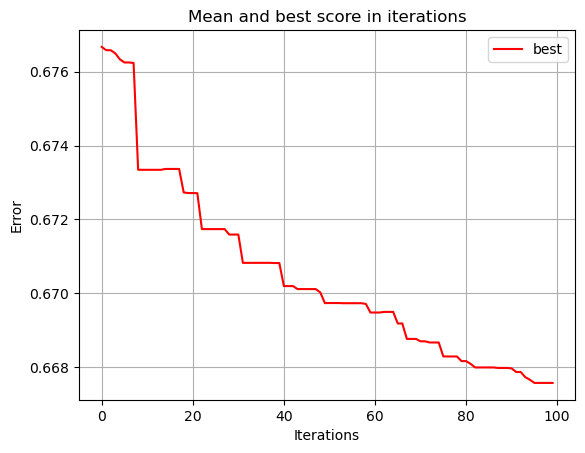

In [190]:
plot_error_history(iris_error_history)
# visualize_speciment(iris_algo.architecture, best_speciment)

# AUTO MPG

In [176]:
autoMPG = pd.read_csv("../data/auto-mpg/auto-mpg.csv").to_numpy()
autoMPG_X = autoMPG[:, range(1,8)]
mask = np.any(autoMPG_X == '?', axis=1)
autoMPG_X = autoMPG_X[~mask].astype(float)
autoMPG_Y = autoMPG[:, 0].astype(float)

autoMPG_X_stand, mean, std = standardize_data(autoMPG_X)
# autoMPG_Y_stand, mean, std = standardize_data(autoMPG_Y)

In [186]:
mpg_algo = genetic_network(architecture=[7, 5, 5, 1], 
                       population_size=100, 
                       initiation_method='he')

mpg_error_history, mpg_best_speciment = mpg_algo.evolve(X = autoMPG_X_stand,
            Y = autoMPG_Y,
            iterations_num = 1000,
            required_error = 10,
            activation_function = sigmoid,
            mutation_step = 0.1,
            mutation_prob = 0.5,
            selection_type = 'roulette',
            elite_ratio = 0.1,
            draft_size = 3,
            show_progess=True)

100%|██████████| 1000/1000 [00:50<00:00, 19.81it/s]


best error 567.8425035342684


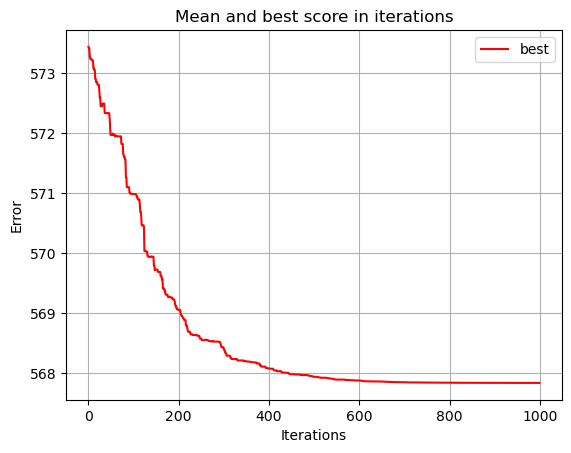

In [187]:
plot_error_history(mpg_error_history)
# visualize_speciment(mpg_algo.architecture, mpg_best_speciment)

# MULTIMODAL LARGE

In [113]:
mml_train = pd.read_csv('../data/regression/multimodal-large-training.csv')[['x', 'y']]
mml_test = pd.read_csv('../data/regression/multimodal-large-test.csv')[['x', 'y']]

mml_train_X = np.array(mml_train['x']).reshape(10000 ,1)
mml_train_Y = np.array(mml_train['y']).reshape(10000 ,1)

mml_test_X = np.array(mml_test['x']).reshape(1000 ,1)
mml_test_Y = np.array(mml_test['y']).reshape(1000 ,1)

mml_train_X_stand, mean, std = standardize_data(mml_train_X)
# autoMPG_Y_stand, mean, std = standardize_data(autoMPG_Y)

In [191]:
mml_algo = genetic_network(architecture=[1, 15, 15, 1], 
                       population_size=100, 
                       initiation_method='he')

mml_error_history, mml_best_speciment = mml_algo.evolve(X = mml_train_X_stand,
            Y = mml_train_Y,
            iterations_num = 1000,
            required_error = 0.1,
            activation_function = sigmoid,
            mutation_step = 0.1,
            mutation_prob = 0.5,
            selection_type = 'roulette',
            elite_ratio = 0.1,
            draft_size = None)

100%|██████████| 1000/1000 [20:22<00:00,  1.22s/it]


best error 5331.760163502082


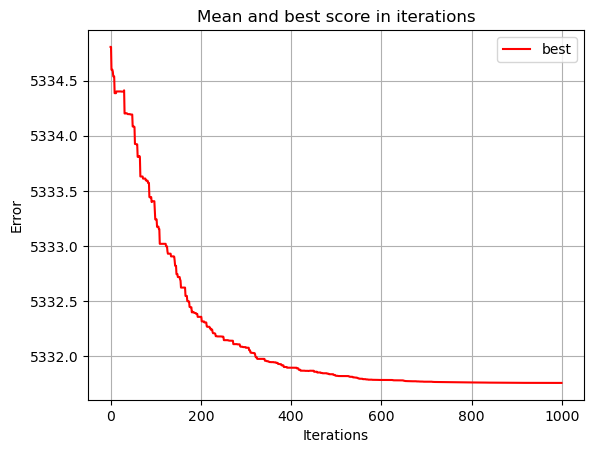

In [193]:
plot_error_history(mml_error_history)
# visualize_speciment(mml_algo.architecture, mml_best_speciment)